## Imports principais

Imports mais generalistas para começar

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from google.colab import files
from math import *
import time
from sklearn import metrics
import sklearn
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Algumas camadas mais relevantes de Keras

In [2]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras import regularizers


from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, Dense, LSTM, concatenate, Bidirectional, SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences

Sklearn para os processamento de Machine Learning clássico

In [3]:
import sklearn.datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import time
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score



Nltk para pré-processamento em NLP

In [4]:
import nltk
nltk.download('punkt')

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Musical_instruments_reviews.csv' new



Mounted at /content/gdrive


## Explorando Dataset

In [6]:
df = pd.read_csv('/content/new')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


As únicas colunas que parecem relevantes são a de reviewText (a opinião em si) e a nota overall

In [7]:
analysis = df[['reviewText','overall']]
analysis

,reviewText,overall
0,"Not much to write about here, but it does exac...",5.0
1,The product does exactly as it should and is q...,5.0
2,The primary job of this device is to block the...,5.0
3,Nice windscreen protects my MXL mic and preven...,5.0
4,This pop filter is great. It looks and perform...,5.0
...,...,...
10256,"Great, just as expected. Thank to all.",5.0
10257,I've been thinking about trying the Nanoweb st...,5.0
10258,I have tried coated strings in the past ( incl...,4.0
10259,"Well, MADE by Elixir and DEVELOPED with Taylor...",4.0


Parece ter uma tendência para notas mais altas

In [8]:
nanValues = analysis.loc[analysis['reviewText'].isnull()]
nanValues

,reviewText,overall
2927,NaN,5.0
4401,NaN,4.0
8739,NaN,5.0
9175,NaN,5.0
9306,NaN,5.0
9313,NaN,5.0
9342,NaN,5.0


Eliminando os valores nulos

In [9]:
analysis = analysis.drop(nanValues.index)

In [10]:
analysis = analysis.dropna()

## Preprocessamento

O pré-processamento abaixo foi baseado no artigo em https://towardsdatascience.com/nlp-preprocessing-with-nltk-3c04ee00edc0#:~:text=Text%20preprocessing%20is%20an%20important%20first%20step%20for,punctuation%2C%20tokenization%2C%20stopword%20filtering%2C%20stemming%2C%20and%20part-of-speech%20tagger e https://towardsdatascience.com/text-preprocessing-with-nltk-9de5de891658 e https://machinelearningknowledge.ai/11-techniques-of-text-preprocessing-using-nltk-in-python/

Para tokenização:https://towardsdatascience.com/5-simple-ways-to-tokenize-text-in-python-92c6804edfc4


Eu tomei um parágrafo qualquer em um dos artigos como base para poder pré-processar.

Para outros recursos
- SVM para NLP: https://chercher.tech/nlp/the-support-vector-machines-svm-algorithm-for-nlp
- Naive Bayes para NLP: https://chercher.tech/nlp/the-naive-bayes-algorithm-for-nlp


In [55]:
def lower(text):
  return text.lower()

def whites(text):
  return " ".join(text.split())

def token(text):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
  tokenizer.fit_on_texts(text)
  return tokenizer

def stopWord(text):
  text = text.split()
  stopWords = nltk.corpus.stopwords.words('english')
  result = []
  for token in text:
    if token not in stopWords:
      result.append(token)
  return result

def punctuation(text):
  import string
  text_p = "".join([char for char in text if char not in string.punctuation])
  return text_p

def stem(text):
  porter = nltk.stem.porter.PorterStemmer()
  stemmed = [porter.stem(word) for word in text]
  return stemmed

def lemmatizeSentence(sentence):
    from nltk.tokenize import word_tokenize
    token_words=word_tokenize(sentence) 
#we need to tokenize the sentence or else lemmatizing will return the entire sentence as is.
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

def postag(words):
   return nltk.pos_tag(words)

In [56]:
text = "In this post, we’ll start with the intuition behind LSTM ’s and GRU’s. Then I’ll explain the internal mechanisms that allow LSTM’s and GRU’s to perform so well. If you want to understand what’s happening under the hood for these two networks, then this post is for you. @             "

In [57]:
def preprocess(text):
  text = lower(text)
  text = whites(text)
  text = punctuation(text)
  text = stopWord(text)
  text = stem(text)
  #text = lemmatizeSentence(text)
  text = postag(text)
  return text

In [58]:
preprocess(text)

[('post', 'NN'),
 ('we’ll', 'JJ'),
 ('start', 'NN'),
 ('intuit', 'NN'),
 ('behind', 'IN'),
 ('lstm', 'JJ'),
 ('’s', 'NNP'),
 ('gru’', 'NN'),
 ('i’ll', 'NN'),
 ('explain', 'VBP'),
 ('intern', 'JJ'),
 ('mechan', 'NN'),
 ('allow', 'VB'),
 ('lstm’', 'JJ'),
 ('gru’', 'NN'),
 ('perform', 'NN'),
 ('well', 'RB'),
 ('want', 'JJ'),
 ('understand', 'NN'),
 ('what’', 'NN'),
 ('happen', 'VB'),
 ('hood', 'NN'),
 ('two', 'CD'),
 ('network', 'NN'),
 ('post', 'NN')]

Para ver a utilização no caso do nosso dataset, eu pré-processei abaixo. Observe que a técnica de vetoriazação e tokenização nos casos de machine learning e deeplearning já lidam com essa parte (vide documentação)

In [59]:
M = analysis['reviewText'].to_numpy()

In [60]:
from google.colab import output
C = []
for i in range(len(M)):
  C.append(preprocess(M[i]))
  #print(M[i])
  #time.sleep(0.5)
  #print(C[i])
  #time.sleep(0.5)
  #output.clear()

In [61]:
np.shape(C)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(10254,)

In [62]:
C[20]

[('cool', 'JJ'),
 ('look', 'NN'),
 ('cheap', 'JJ'),
 ('cabl', 'NN'),
 ('work', 'NN'),
 ('well', 'RB'),
 ('bent', 'JJ'),
 ('one', 'CD'),
 ('connector', 'NN'),
 ('pretti', 'NN'),
 ('badli', 'NN'),
 ('fault', 'NN'),
 ('one', 'CD'),
 ('thing', 'NN'),
 ('consid', 'NN'),
 ('cabl', 'NN'),
 ('tighten', 'JJ'),
 ('connector', 'NN'),
 ('awhil', 'NN'),
 ('youll', 'NN'),
 ('abl', 'NN'),
 ('hear', 'VBP'),
 ('rattl', 'NN'),
 ('seem', 'VBP'),
 ('retro', 'JJ'),
 ('look', 'NN'),
 ('screw', 'VBD'),
 ('connector', 'JJ'),
 ('black', 'JJ'),
 ('rubber', 'NN'),
 ('cabl', 'JJ'),
 ('look', 'NN'),
 ('cool', 'JJ'),
 ('work', 'NN'),
 ('welli', 'NN'),
 ('also', 'RB'),
 ('shorter', 'RB'),
 ('red', 'JJ'),
 ('cabl', 'NN'),
 ('goe', 'NN'),
 ('one', 'CD'),
 ('guitar', 'NN'),
 ('perfectli', 'NN'),
 ('bought', 'VBD'),
 ('these', 'DT'),
 ('use', 'VBP'),
 ('practic', 'JJ'),
 ('other', 'JJ'),
 ('use', 'NN'),
 ('black', 'JJ'),
 ('cabl', 'NN'),
 ('easier', 'JJR'),
 ('plug', 'NN'),
 ('differ', 'NN'),
 ('amp', 'NN'),
 ('without'

## Vetorização sklearn

Texto de base para vetorização TFIDF foi: https://medium.com/@vasista/sentiment-analysis-using-svm-338d418e3ff1#:~:text=Sentiment%20Analysis%20using%20SVM%20Sentiment%20Analysis%20is%20the,of%20data%20i.e.%2C%20Business%2C%20Politics%2C%20Social%20Media%2C%20etc.%2C

Observe que a vetorização tfidf permite o pré-processamento como parte de seus parâmetros, vide documentação: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [63]:
X_train, X_test, y_train, y_test = train_test_split(analysis['reviewText'], analysis['overall'], test_size = 0.2, random_state = 1)


In [64]:
X_train, X_test, y_train, y_test = X_train.values.astype('U'), X_test.values.astype('U'), y_train.values.astype('U'), y_test.values.astype('U')

In [65]:
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True,
                             stop_words = 'english')
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [66]:
np.shape(train_vectors)

(8203, 5274)

Não é possível visualizar isso em um gráfico devido à dimensão nos train_vectors

### SVM Classsifier

Classificador SVM tenta interpor a melhor barreira flexível entre dois conjuntos de dados. Abaixo testei 3 kernels diferentes, cujos resultados estão nos comentários

In [67]:
classifier = svm.SVC(kernel='linear')
#classifier = svm.SVC(kernel='poly', degree=8)
#classifier = svm.SVC(kernel='rbf')
t0 = time.time()
classifier.fit(train_vectors, y_train)
t1 = time.time()
prediction = classifier.predict(test_vectors)
t2 = time.time()
time_train = t1-t0
time_predict = t2-t1


In [68]:
print('Tempo de treino: ', time_train, 's')
print('Tempo de predição: ', time_predict, 's')

print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

Tempo de treino:  20.978184461593628 s
Tempo de predição:  3.3191895484924316 s
[[   3    1    2    3   41]
 [   2    0    5   10   29]
 [   0    0    8   16  140]
 [   0    0    5   39  338]
 [   0    0    2   32 1375]]
              precision    recall  f1-score   support

         1.0       0.60      0.06      0.11        50
         2.0       0.00      0.00      0.00        46
         3.0       0.36      0.05      0.09       164
         4.0       0.39      0.10      0.16       382
         5.0       0.72      0.98      0.83      1409

    accuracy                           0.69      2051
   macro avg       0.41      0.24      0.24      2051
weighted avg       0.61      0.69      0.61      2051



Veja que na prática a classificação não foi ruim para um núcleo linear(vide matriz de confusão). As previsões tendem a ficar dentro de uma boa margem. Nos outros dois casos, há uma evidente tendência a classificar tudo com 5 estrelas. Na perspectiva da Amazon e de futuros compradores, uma classificação mais baixa com um produto bom é preferível a uma mais alta com produto ruim, na ideia de melhorias, é claro.

Caso rbf:


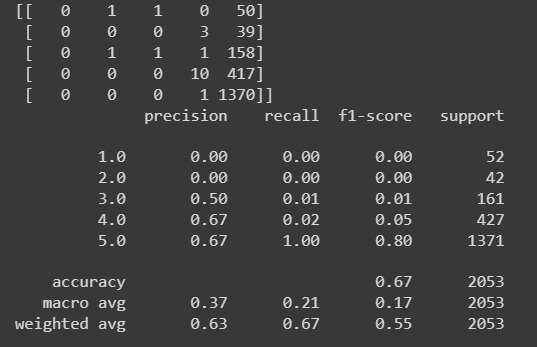

Caso polinomial:

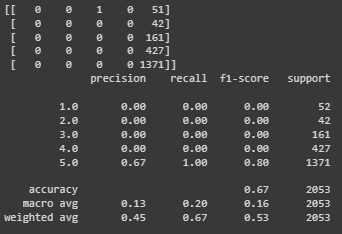

In [69]:
print(accuracy_score(y_test, prediction))

0.6947830326669917


### Naive Bayes classifier

Naive bayes é um algoritmo baseado em estatística bayesiana

In [70]:
np.shape(train_vectors)

(8203, 5274)

In [71]:
model_bayes = MNB()
t0 = time.time()
model_bayes.fit(train_vectors, y_train)
t1 = time.time()
prediction_bayes = model_bayes.predict(test_vectors)
t2 = time.time()
time_train = t1-t0
time_predict = t2-t1


In [74]:
print('Tempo de treino: ', time_train, 's')
print('Tempo de predição: ', time_predict, 's')

print(confusion_matrix(y_test, prediction_bayes))
print(classification_report(y_test, prediction_bayes))

Tempo de treino:  0.02352118492126465 s
Tempo de predição:  0.001264810562133789 s
[[   0    0    0    1   49]
 [   0    0    0    0   46]
 [   0    0    0    0  164]
 [   0    0    0    1  381]
 [   0    0    0    3 1406]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        50
         2.0       0.00      0.00      0.00        46
         3.0       0.00      0.00      0.00       164
         4.0       0.20      0.00      0.01       382
         5.0       0.69      1.00      0.81      1409

    accuracy                           0.69      2051
   macro avg       0.18      0.20      0.16      2051
weighted avg       0.51      0.69      0.56      2051



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
print(accuracy_score(y_test, prediction_bayes))

0.6860068259385665


O resultado final para Naive Bayes foi parecido ao caso polinomial, e simplesmente não classifica bem os comentários.


## Tensolflow e RNN

### Tokenizer

Nível caracter (tokenizerChar) e nível palavra (tokenizerWord)
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer. Os códigos abaixo também foram adaptados do livro texto

In [11]:
tokenizerChar = keras.preprocessing.text.Tokenizer(char_level = True)
tokenizerChar.fit_on_texts(analysis['reviewText'])

In [12]:
tokenizerChar.texts_to_sequences(
    ['start']
)

[[7, 3, 4, 9, 3]]

In [13]:
len(tokenizerChar.word_index)

68

Vamos usar tokenização de palavras daqui para frente

In [14]:
tokenizerWord = keras.preprocessing.text.Tokenizer(num_words = 10000, lower = True, oov_token = 'oov')
tokenizerWord.fit_on_texts(analysis['reviewText'])

Abaixo eu uso padding para fazer com que todas as sentenças tenham o mesmo tamanho, o que facilita o trabalho da RNN. get_dummies faz y ter formato one-hot, o que facilita quando precisarmos passar o processamento pela softmax na RNN.

In [15]:
x = tokenizerWord.texts_to_sequences(analysis['reviewText'])
x = pad_sequences(x)
y = pd.get_dummies(analysis['overall'])


In [16]:
print(y)

       1.0  2.0  3.0  4.0  5.0
0        0    0    0    0    1
1        0    0    0    0    1
2        0    0    0    0    1
3        0    0    0    0    1
4        0    0    0    0    1
...    ...  ...  ...  ...  ...
10256    0    0    0    0    1
10257    0    0    0    0    1
10258    0    0    0    1    0
10259    0    0    0    1    0
10260    0    0    0    1    0

[10254 rows x 5 columns]


In [17]:
y = y.values

Segue que 5 estrelas está associado a 00001 no onehot encoder. Abaixo eu crio um dataframe com os tokens de X e empilhado com y em formato onehot

In [18]:
data_tokenized = np.hstack((x, y))
x_column_names = ["Tokenized_" + str(i) for i in range(x.shape[1])]
y_column_names = ["1 Star","2 Star","3 Star","4 Star","5 Star"]
column_names = x_column_names + y_column_names

df_tokenized = pd.DataFrame(data_tokenized, columns = column_names)

data = df_tokenized.drop(["1 Star","2 Star","3 Star","4 Star","5 Star"], axis =1)

In [19]:
np.shape(data_tokenized)

(10254, 2064)

In [20]:
np.shape(x)

(10254, 2059)

In [21]:
np.shape(y)

(10254, 5)

In [22]:
data_tokenized

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int32)

In [23]:
X_trainRNN, X_testRNN, y_trainRNN, y_testRNN = train_test_split(data, df_tokenized[["1 Star","2 Star","3 Star","4 Star","5 Star"]],test_size = 0.2)

In [24]:
y_trainRNN.head()

,1 Star,2 Star,3 Star,4 Star,5 Star
7564,0,0,1,0,0
289,0,0,0,0,1
6595,0,1,0,0,0
8905,0,0,0,0,1
8999,0,0,0,1,0


### RNN

O texto base para a SimpleRNN foi o seguinte: https://deephaven.io/blog/2022/02/08/learn-tensorflow/#:~:text=TensorFlow%20enables%20data%20scientists%20to%20create%20sophisticated%2C%20large-scale,a%20natural%20pairing%20for%20AI%20libraries%20like%20TensorFlow.

Nesse código eu tive alguns problemas de dimensão. É importante escrever return_sequences = False na camada SimpleRNN

In [25]:
X_trainRNN.shape[1]

2059

In [26]:
embed_dim = 128
max_features = 10000

model = keras.models.Sequential([
    keras.layers.Embedding(max_features, embed_dim, input_length = X_trainRNN.shape[1]),
    keras.layers.SpatialDropout1D(0.4),
    keras.layers.SimpleRNN(128, return_sequences=False,dropout=0.2, recurrent_dropout=0.2),
    #keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2059, 128)         1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 2059, 128)        0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,321,477
Trainable params: 1,321,477
Non-trainable params: 0
______________________________________________

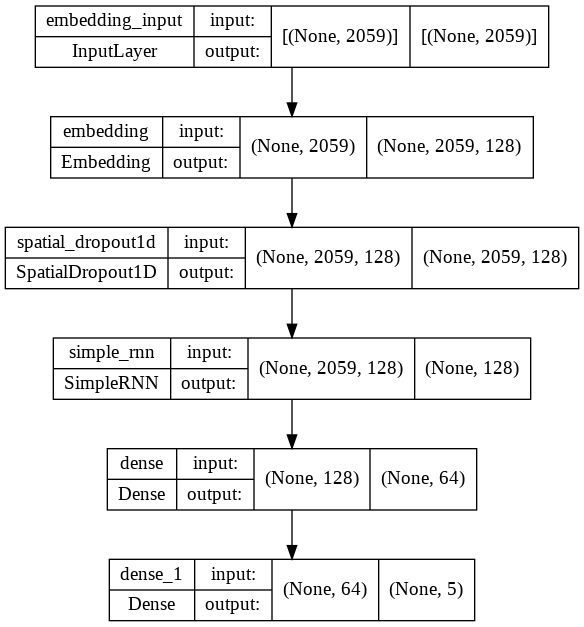

In [27]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
tf.keras.utils.plot_model(model, show_shapes = True)

Abaixo temos o treinamento da rede. É um tratamento longo e que percebi que o número de épocas pouco influencia, portanto essa linha foi comentada 

In [28]:
ES = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=3)

In [29]:
t0 = time.time()
model.fit(X_trainRNN, 
          y_trainRNN,
          #epochs = 10,
          batch_size=32,
          #callbacks = ES
          )
t1 = time.time()
time_train = t1-t0
print('Tempo de treino: ', time_train, 's')

257/257 [==============================] - 1156s 4s/step - loss: 1.0578 - accuracy: 0.6470
Tempo de treino:  1163.67316532135 s


In [40]:
t1 = time.time()
y_hat = model.predict(X_testRNN)
t2 = time.time()
time_predict = t2-t1


In [41]:
a = np.max(y_hat,axis = 1)
y_predict = np.zeros(np.shape(y_hat))

In [42]:
for i in range(len(y_hat)):
  y_predict[i] = y_hat[i]==a[i]

In [44]:
accuracy_score(y_testRNN,y_predict)

0.6699171136031205

### LSTM

Para usar uma LSTM, basta trocar a linha equivalente da SimpleRNN

In [45]:
embed_dim = 128
max_features = 10000
lstm_out = 196

modelLSTM = keras.models.Sequential([
    keras.layers.Embedding(max_features, embed_dim, input_length = X_trainRNN.shape[1]),
    keras.layers.SpatialDropout1D(0.4),
    keras.layers.LSTM(lstm_out,return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    #keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])
modelLSTM.compile(loss="categorical_crossentropy", optimizer="adam",metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2059, 128)         1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 2059, 128)        0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,321,477
Trainable params: 1,321,477
Non-trainable params: 0
______________________________________________

In [46]:
t0 = time.time()
modelLSTM.fit(X_trainRNN, 
          y_trainRNN,
          #epochs = 10,
          batch_size=32
          #callbacks = ES
          )
t1 = time.time()
time_train = t1-t0
print('Tempo de treino: ', time_train, 's')

257/257 [==============================] - 2975s 12s/step - loss: 0.9540 - accuracy: 0.6763
Tempo de treino:  3025.2320642471313 s


In [47]:
t1 = time.time()
y_hat = model.predict(X_testRNN)
t2 = time.time()
time_predict = t2-t1
a = np.max(y_hat,axis = 1)
y_predict = np.zeros(np.shape(y_hat))
for i in range(len(y_hat)):
  y_predict[i] = y_hat[i]==a[i]
accuracy_score(y_testRNN,y_predict)

0.6699171136031205

### BRNN
Para usar uma Biderectional - RNN, basta trocar a linha equivalente da SimpleRNN

In [51]:
embed_dim = 128
max_features = 10000
lstm_out = 196

modelBRNN = keras.models.Sequential([
    keras.layers.Embedding(max_features, embed_dim, input_length = X_trainRNN.shape[1]),
    keras.layers.SpatialDropout1D(0.4),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])
modelBRNN.compile(loss="categorical_crossentropy", optimizer="adam",metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2059, 128)         1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 2059, 128)        0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,321,477
Trainable params: 1,321,477
Non-trainable params: 0
______________________________________________

In [52]:
t0 = time.time()
modelBRNN.fit(X_trainRNN, 
          y_trainRNN,
          #epochs = 10,
          batch_size=32
          #callbacks = ES
          )
t1 = time.time()
time_train = t1-t0
print('Tempo de treino: ', time_train, 's')

257/257 [==============================] - 6175s 24s/step - loss: 0.9448 - accuracy: 0.6755
Tempo de treino:  6175.006212472916 s


In [53]:
t1 = time.time()
y_hat = modelBRNN.predict(X_testRNN)
t2 = time.time()
time_predict = t2-t1
y_predict = np.round(y_hat)
a = np.max(y_hat,axis = 1)
y_predict = np.zeros(np.shape(y_hat))
for i in range(len(y_hat)):
  y_predict[i] = y_hat[i]==a[i]
accuracy_score(y_testRNN,y_predict)

0.6728425158459288

Vemos que da maneira como os dados estão processados, nenhum algoritmo passa dos 70%. Não só a complexidade de NLP entra em jogo, como a arquitetura em si utilizada é bem simples (só uma rede RNN em cada caso sem nenhuma otimização ou atenção a outras estruturas), assim como os dados estão desbalanceados (há uma maioria de avaliações 5 estrelas, o que é bem evidenciado pelas previsoes feitas pelos algoritmos SVM e naive bayes). Os tempos de treinamento e as acurácias finais estão mostradas na tabela abaixo

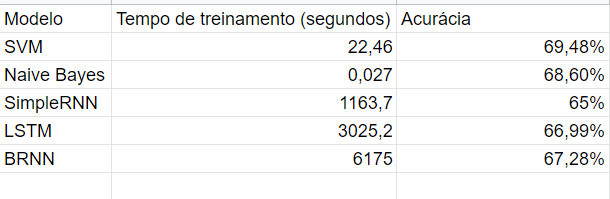

## Descartes

Abaixo temos alguns dos códigos descartados quando da codagem

### Descarte de vetorização

In [ ]:
A = analysis['reviewText'].values.astype('U')
B = analysis['overall'].values.astype('U')

In [ ]:
vect = TfidfVectorizer(stop_words='english',lowercase=True).fit(A)

In [ ]:
tfidf_vector_X = vect.transform(A).toarray()
tfidf_vector_Y = vect.transform(B).toarray()
#tfidf_vector_X = tfidf_vector_X[:, :, None] 
#tfidf_vector_Y = tfidf_vector_Y[:, :, None] 

In [ ]:
tfidf_vector_X[300].sum()

3.73347020673827

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vector_X, tfidf_vector_Y, test_size = 0.2, random_state = 1)


In [ ]:
X_train

array(['This MXL Studio 24 USB Microphone is a decent choice for those needing a portable or a good quality studio microphone. We professionally produce instructional videos, both at our shop and at customer locations, and often need to voice over footage. This mic will replace theBlue Microphones Snowball USB Microphone (Textured White)we use in studio and also theMXL Mics MXL-STUDIO 1 USB Condenser Microphone, Cardioidwe had previously used for off-site recording.Pros -* Good Voice Quality; cleanly captures spoken voices* Good Physical Quality; this is beefy mic that feels very well made* Looks Professional; while not important to the functionality, it makes a good impression on our customers* Long USB Cord; allows for placement away from PC* Headphone Jack; "real time monitor", handy to listen to live recording and playback* Travels Well; includes a protective travel case that fits all of componentsCons -* No Pop-Filter Included; normally I wouldn\'t mention this but the instruction


### SVM descarte

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train.shape

(8208, 20251)

In [ ]:
scaler = StandardScaler() 
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.fit_transform(X_test)

In [ ]:
classifier = SVC(kernel='linear')

In [ ]:
classifier.fit(X_train, y_train)

ValueError: ignored

In [ ]:
A = vectorizer.build_preprocessor()

In [ ]:
B = A(analysis['reviewText'].values.astype('U'))

AttributeError: ignored

In [ ]:
np.shape(X)

(10261, 20551)

In [ ]:
tokens = vectorizer.get_feature_names_out()
tokens[20]

'011s'

In [ ]:
df_tfidfvect = pd.DataFrame(data = x.toarray(),index = ['Doc1','Doc2'],columns = tokens)

ValueError: ignored

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd
# set of documents
train = ['The sky is blue.','The sun is bright.']
test = ['The sun in the sky is bright', 'We can see the shining sun, the bright sun.']
# instantiate the vectorizer object
tfidfvectorizer = TfidfVectorizer()
# convert th documents into a matrix
tfidf_wm = tfidfvectorizer.fit_transform(train)
#retrieve the terms found in the corpora
# if we take same parameters on both Classes(CountVectorizer and TfidfVectorizer) , it will give same output of get_feature_names() methods)
#count_tokens = tfidfvectorizer.get_feature_names() # no difference
tfidf_tokens = tfidfvectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = ['Doc1','Doc2'],columns = tfidf_tokens)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)


TD-IDF Vectorizer

          blue    bright        is       sky       sun       the
Doc1  0.576152  0.000000  0.409937  0.576152  0.000000  0.409937
Doc2  0.000000  0.576152  0.409937  0.000000  0.576152  0.409937


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = ["Good morning", "Sweet Dreams", "Stay Awake"]
Y = ["Good morning", "Sweet Dreams", "Stay Awake"]

vectorizer = TfidfVectorizer().fit(X)

tfidf_vector_X = vectorizer.transform(X).toarray()  #//shape - (3,6)
tfidf_vector_Y = vectorizer.transform(Y).toarray() #//shape - (3,6)
tfidf_vector_X = tfidf_vector_X[:, :, None] #//shape - (3,6,1) 
tfidf_vector_Y = tfidf_vector_Y[:, :, None] #//shape - (3,6,1)

X_train, X_test, y_train, y_test = train_test_split(tfidf_vector_X, tfidf_vector_Y, test_size = 0.2, random_state = 1)

from keras import Sequential
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(units=6, input_shape = X_train.shape[1:], return_sequences = True))
model.add(LSTM(units=6, return_sequences=True))
model.add(LSTM(units=6, return_sequences=True))
model.add(LSTM(units=1, return_sequences=True, name='output'))
model.compile(loss='cosine_proximity', optimizer='sgd', metrics = ['accuracy'])

print(model.summary())

model.fit(X_train, y_train, epochs=1, verbose=1)

numpy.ndarray